In [1]:
from copy import deepcopy
from segment_polarity_model import SegmentPolarityModel
from attractor_data import wild_type_true_attractors, wild_type_initial
import pickle
from collections import Counter
import random
import os
from itertools import combinations
from sklearn.cluster import DBSCAN, OPTICS
from statistics import mean, median, stdev as std
import numpy as np
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
from umap import UMAP
from util import distinct_colors
from matplotlib import patheffects

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
import interactions

In [4]:
datadir='/home/bglaze/segment_polarity/data'
tmstp='20210415-1427'

In [5]:
f = open(f'{datadir}/models/best_models/best_models_clusters_tmstp-{tmstp}.pickle','rb')

In [6]:
clusters = pickle.load(f)
all_models = []
for cluster, models in clusters.items():
    all_models += models

In [7]:
len(all_models)

50000

In [8]:
all_paths = []
unique_paths = set()

lstates = Counter()
lattrs = Counter()

for model in all_models:
    spm = SegmentPolarityModel(rules=model)
    spm.compile_rules()
    (stable, cyclic), path = spm.simulate(wild_type_initial, return_states=True)
    path = tuple(path)
    if path not in unique_paths:
        lstates[len(path)]+=1
        lattrs[(len(stable), len(cyclic))]+=1
    # normally simulate returns a path for every start state
    # here we only have one start state
    all_paths.append(path)
    unique_paths.add(path)
    

In [9]:
path_models = dict()
for i in range(len(all_models)):
    model = all_models[i]
    path = all_paths[i]
    if path not in path_models: path_models[path] = []
    path_models[path].append(model)

In [10]:
print("path lengths")
print('length -> count')
for path_length, count in lstates.most_common():
    print(f'{path_length:2d} -> {count}')
print('')
print("Number of attractors")
print("Stable, cyclic -> count")
for (stable,cyclic), count in lattrs.most_common():
    print(f'{stable}, {cyclic} -> {count}')
print('')
print("Number of total paths", len(all_paths))
print("Number of unique paths", len(unique_paths))
print('-')

unique_paths = sorted(unique_paths)
    

path lengths
length -> count
 7 -> 799
19 -> 521
17 -> 503
 8 -> 471
18 -> 452
12 -> 416
 9 -> 301
 6 -> 271
10 -> 258
14 -> 221
13 -> 191
 5 -> 173
11 -> 156
20 -> 53
15 -> 36
21 -> 35
27 -> 20
16 -> 18
24 -> 17
28 -> 17
23 -> 8
22 -> 7
37 -> 3
25 -> 3
35 -> 3
32 -> 2
34 -> 1
36 -> 1
30 -> 1
65 -> 1
26 -> 1
31 -> 1

Number of attractors
Stable, cyclic -> count
1, 0 -> 4961

Number of total paths 50000
Number of unique paths 4961
-


In [11]:
class DiscreteFrechet(object):
    """F`
    Calculates the discrete Fréchet distance between two poly-lines using the
    original recursive algorithm
    """

    def __init__(self, dist_func):
        """
        Initializes the instance with a pairwise distance function.
        :param dist_func: The distance function. It must accept two NumPy
        arrays containing the point coordinates (x, y), (lat, long)
        """
        self.dist_func = dist_func
        self.ca = np.array([0.0])

    def distance(self, p, q) -> float:
        """
        Calculates the Fréchet distance between poly-lines p and q
        This function implements the algorithm described by Eiter & Mannila
        :param p: Poly-line p
        :param q: Poly-line q
        :return: Distance value
        """

        def calculate(i, j) -> float:
            """
            Calculates the distance between p[i] and q[i]
            :param i: Index into poly-line p
            :param j: Index into poly-line q
            :return: Distance value
            """
            if self.ca[i, j] > -1.0:
                return self.ca[i, j]
            
            d = sqrt((i-j)**2 + self.dist_func(p[i], q[j])**2)
            if i == 0 and j == 0:
                self.ca[i, j] = d
            elif i > 0 and j == 0:
                self.ca[i, j] = max(calculate(i-1, 0), d)
            elif i == 0 and j > 0:
                self.ca[i, j] = max(calculate(0, j-1), d)
            elif i > 0 and j > 0:
                self.ca[i, j] = max(min(calculate(i-1, j),
                                        calculate(i-1, j-1),
                                        calculate(i, j-1)), d)
            else:
                self.ca[i, j] = np.infty
            return self.ca[i, j]

        n_p = len(p)
        n_q = len(q)
        self.ca = np.zeros((n_p, n_q))
        self.ca.fill(-1.0)
        return calculate(n_p - 1, n_q - 1)

In [12]:
class MinShift(object):
    """
    Analogue to the discrete Frechet distance that accumulates the "leash lengths"
    required to connect one polyline to another
    """
    def __init__(self, dist_func):
        self.dist_func = dist_func
        self.ca = np.array([0.0])

    def distance(self, p, q) -> float:

        def calculate(i, j) -> float:
            if self.ca[i, j] > -1.0:
                return self.ca[i, j]
            
            d = self.dist_func(p[i], q[j])
            if i == 0 and j == 0:
                self.ca[i, j] = d
            elif i > 0 and j == 0:
                self.ca[i, j] = calculate(i-1, 0) + d
            elif i == 0 and j > 0:
                self.ca[i, j] = calculate(0, j-1) + d
            elif i > 0 and j > 0:
                self.ca[i, j] = min(calculate(i-1, j-1),
                                    calculate(i-1, j),
                                    calculate(i, j-1)) + d
            else:
                self.ca[i, j] = np.infty
            return self.ca[i, j]

        n_p = len(p)
        n_q = len(q)
        self.ca = np.zeros((n_p, n_q))
        self.ca.fill(-1.0)
        return calculate(n_p - 1, n_q - 1)

### Longest common subsequence

In [13]:
# Returns length of LCS for X[0..m-1], Y[0..n-1]  
def lcs(X, Y): 
    m = len(X)
    n = len(Y)
    L = [[0 for x in range(n+1)] for x in range(m+1)] 
  
    # Following steps build L[m+1][n+1] in bottom up fashion. Note 
    # that L[i][j] contains length of LCS of X[0..i-1] and Y[0..j-1]  
    for i in range(m+1): 
        for j in range(n+1): 
            if i == 0 or j == 0: 
                L[i][j] = 0
            elif X[i-1] == Y[j-1]: 
                L[i][j] = L[i-1][j-1] + 1
            else: 
                L[i][j] = max(L[i-1][j], L[i][j-1]) 
  
    # Following code is used to print LCS 
    index = L[m][n] 
  
    # Create a character array to store the lcs string 
    lcs = [None] * (index) 
  
    # Start from the right-most-bottom-most corner and 
    # one by one store characters in lcs[] 
    i = m 
    j = n 
    while i > 0 and j > 0: 
  
        # If current character in X[] and Y are same, then 
        # current character is part of LCS 
        if X[i-1] == Y[j-1]: 
            lcs[index-1] = X[i-1] 
            i-=1
            j-=1
            index-=1
  
        # If not same, then find the larger of two and 
        # go in the direction of larger value 
        elif L[i-1][j] > L[i][j-1]: 
            i-=1
        else: 
            j-=1
  
    return lcs


In [14]:
def minimumEditDistance(s1,s2, d):
    if len(s1) > len(s2):
        s1,s2 = s2,s1
    distances = range(len(s1) + 1)
    for index2,state2 in enumerate(s2):
        newDistances = [index2+1]
        for index1,state1 in enumerate(s1):
            if state1 == state2:
                newDistances.append(distances[index1])
            else:
                newDistances.append(d(state1, state2) + min((distances[index1], # deletion
                                                             distances[index1+1], # insertion
                                                             newDistances[-1]))) # replacement
        distances = newDistances
    return distances[-1]

In [15]:
def state_distance(a, b):
    a = dict(a)
    b = dict(b)
    d = 0.0
    for k in a.keys():
        d += 0 if a[k] == b[k] else 1
    return d/len(a)

In [16]:
distance_file = f'minshift_distances-tmstp-{tmstp}.npy'
n = len(unique_paths)
nc = int(n*(n-1)/2)

if not os.path.exists(distance_file):
    from joblib import Parallel, delayed
    from math import ceil
    minshift = MinShift(state_distance)


    
    distances = np.memmap(distance_file, dtype=float,
                   shape=nc, mode='w+')
    idxs = list(enumerate(combinations(range(len(unique_paths)),r=2)))
    def write_dist(job_id, idxs):
        c=0
        d=0
        t=len(idxs)
        for i,(a,b) in idxs:
            p = unique_paths[a]
            q = unique_paths[b]
            distances[i] = minshift.distance(p,q)
            c+=1
            if c==10000:
                d+=1
                print(job_id, f'{(c*d)/t*100:.0f}%')
                c=0
    n_jobs = 40
    parallel = Parallel(n_jobs=n_jobs, verbose=9, backend='multiprocessing')
    slice_size = ceil(len(idxs)/n_jobs)
    parallel(delayed(write_dist)(i, idxs[(i*slice_size):(i+1)*slice_size]) for i in range(n_jobs))
else:
    distances = np.memmap(distance_file, mode='r', shape=nc, dtype=float)
    dm = squareform(distances)

In [17]:
dm.shape

(4961, 4961)

In [18]:
umap = UMAP(metric='precomputed', random_state=42)

In [19]:
projected = umap.fit_transform(dm)

/home/bglaze/miniconda3/envs/segment_polarity/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [20]:
path_clusters = dict()

# dbscan = DBSCAN(metric='precomputed', eps=.15) 
dm = squareform(distances)
# clusters = dbscan.fit_predict(dm)

dbscan = DBSCAN(eps=1, min_samples=50)
clusters = dbscan.fit_predict(projected)

path_clusters = {}
for i,idx in enumerate(clusters):
    if idx not in path_clusters:
        path_clusters[idx] = []
    path_clusters[idx].append(unique_paths[i])
    
cluster_counts = sorted([(cluster, len(path_clusters[cluster]))
                            for cluster in path_clusters])

print('Cluster|Count|Mean distance|Mean Length|Std. length')
for cluster,count in cluster_counts:
    idxs = np.argwhere(clusters == cluster).flatten()
    combos = list(combinations(idxs,r=2))
    ds = np.zeros(len(combos))
    i=0
    for combo in combos:
        ds[i] = dm[combo]
        i+=1
    lens = [len(unique_paths[i]) for i in idxs]
    if len(lens) > 1:
        v = std(lens)
    else:
        v =0
    print(f'{cluster:7d} {count:5d} {ds.mean():13.4f} {mean(lens):11.2f} {v:11.2f}')


Cluster|Count|Mean distance|Mean Length|Std. length
     -1   373        1.1313       11.29        4.97
      0   407        0.4075       13.17        1.25
      1   112        0.1309        6.18        0.88
      2   324        0.2942       18.20        0.65
      3    61        0.4227       18.07        0.25
      4   176        0.4556       10.43        1.37
      5   204        0.7641       21.06        5.18
      6   131        0.4238       19.27        2.16
      7   329        0.5390       19.39        1.32
      8    65        0.3104       11.85        1.29
      9    70        0.1787       16.99        0.12
     10   174        0.4233       12.73        1.57
     11   124        0.1934       16.99        0.20
     12   349        0.3430        8.63        1.51
     13   221        0.2438       12.20        0.66
     14   365        0.2531        6.25        1.83
     15   314        0.3608       17.25        1.55
     16   132        0.2189        8.39        1.10
     17   35

In [21]:
pickle.dump(path_clusters, open(f'path_clusters_{tmstp}.pickle','wb'))

### Check that the distances are calculated correctly after a previous mess up

In [22]:
# print(np.mean([minshift.distance(unique_paths[a], unique_paths[b]) for a,b in combinations(idxs[:20].flatten(),r=2)]))
# print(np.mean([dm[(a,b)] for a,b in combinations(idxs[:20].flatten(),r=2)]))

In [23]:
header = 'Cluster|Mean Distances|Std. Dists|Mean Path Lens|Std Path Lens'
widths = [len(h) for h in header.split('|')]

In [24]:
widths

[7, 14, 10, 14, 13]

In [25]:
# Select a random subset of distances from the distance matrix, of the same size as the 
# clusters chosen by DBSCAN
# Compute the mean of all the random distances
# We can compare this to the same calculation performed above for the distances between items 
# in the actual DBSCAN clusters. The random distances should be significantly larger
# This is a sanity check that the DBSCAN clusters are different than random
n_cluster_samples = 10
n_repeat = 5
print('Cluster|Mean Distances|Std. Dists|Mean Path Lens|Std Path Lens')
for cluster in random.choices(list(path_clusters.keys()), k=n_cluster_samples):
    mean_dists = []
    for i in range(n_repeat):
        random_idxs = np.random.choice(list(range(len(unique_paths))), size=dict(cluster_counts)[cluster])

        random_distances = squareform(distances)[random_idxs][:,random_idxs]
        mean_dists.append(random_distances.mean())
        
    lens = [len(unique_paths[i]) for i in random_idxs.flatten()]
        
    print(f'{cluster:7d} {np.mean(mean_dists):14.3f} {np.std(mean_dists):10.3f} {np.mean(lens):14.3f} {np.std(lens):13.3f}')

Cluster|Mean Distances|Std. Dists|Mean Path Lens|Std Path Lens
     13          1.053      0.023         11.851         5.633
      0          1.112      0.016         12.000         5.381
      5          1.060      0.027         12.235         5.392
     -1          1.115      0.008         12.174         5.165
     15          1.117      0.027         12.522         5.055
     13          1.145      0.028         12.719         5.226
     18          1.098      0.028         12.825         5.420
      1          1.100      0.045         12.080         5.392
      8          1.069      0.034         12.108         5.129
      0          1.124      0.025         12.776         5.447


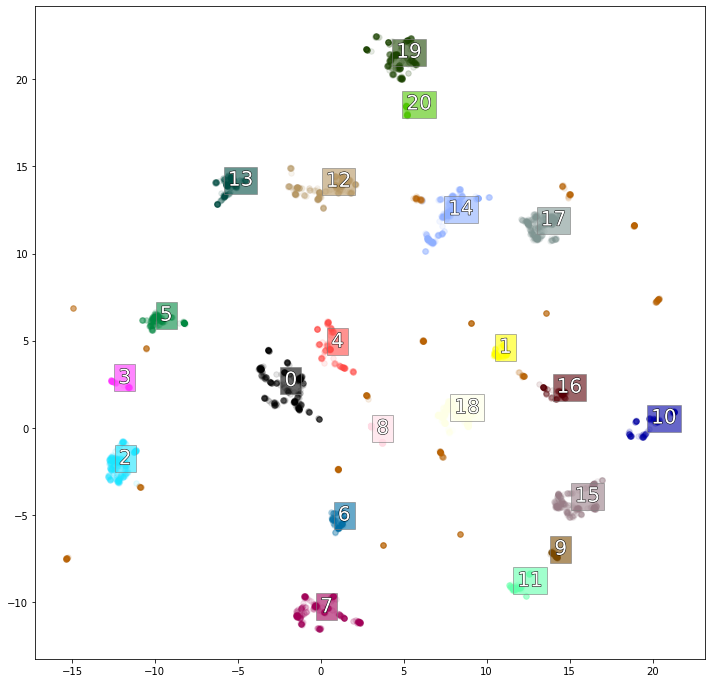

In [26]:
colors = distinct_colors(len(clusters))

plt.figure(figsize=(12,12))
for cluster in set(clusters):
    idxs = np.argwhere(clusters==cluster).flatten()
    points = projected[idxs]
    if cluster!=-1:
        t = plt.text(np.mean(points[:,0]), np.mean(points[:,1]), 
                     cluster, 
                     fontsize=20,
                     c='white'
                    )
        t.set_path_effects([patheffects.withStroke(linewidth=1, foreground='k')])
        t.set_bbox(dict(facecolor=colors[cluster], alpha=0.6, edgecolor='grey'))
    plt.scatter(points[:,0], points[:,1], s=30, color=colors[cluster], alpha=.1)

#         plt.annotate(cluster,
#                      xy=(, np.mean(points[:,1])),
#                      size=20,
#                      c='white'
                     
#                     )

## Find features that are unique to each cluster

In [27]:
def print_state(state):
    nodes = ['wg', 'WG', 'en', 'EN', 'hh', 'HH', 'ptc', 'PTC', 'PH', 'SMO', 'ci', 'CI', 'CIA', 'CIR', 'SLP', ]
    cells = range(0,4)
    d = dict(state)
    for node in nodes:
        print(f'{node:5s}',end='')
        for cell in cells:
            key = (node,cell)
            v = 1 if d[key] else 0
            print(v, end='')
        print('')

## States in each cluster that aren't part of a common subsequence with members of another cluster

In [28]:
common_states = {cluster:Counter() for cluster in path_clusters.keys()}

for cluster in path_clusters:
    pc = path_clusters[cluster]
    sample = random.sample(pc, k=min(100, len(pc)))
    n = len(sample)
    for path in sample:
        for state in path:
            common_states[cluster][state] += 1/n

In [29]:
class Avg():
    def __init__(self):
        self.count = 0
        self.value = 0
    
    def __iadd__(self, x):
        self.count += 1
        self.value += x
        return self

    def __lt__(self, x):
        return self.avg() < x
    
    def __gt__(self, x):
        return self.avg() > x
    
    def avg(self):
        return self.value/self.count
    
    def __repr__(self):
        return str(self.value/self.count)

In [30]:
class Averager(Counter):
    def __init__(self):
        super().__init__()
        
    def __missing__(self, x):
        return Avg()
    
    def __repr__(self):
        return('\n'.join([f'{k}: {v.avg()}' for k,v in self.most_common()]))


In [31]:
uncommon_states = {}
comparison_count = {}
path_presence_count = {}

cluster_pairs = list(combinations(path_clusters.keys(), r=2))
uncommon_states = {cluster:Counter() for cluster in path_clusters.keys()}
sample_count = {cluster:Counter() for cluster in path_clusters.keys()}
comparison_count = len(path_clusters)-2

i=0
for cluster1, cluster2 in cluster_pairs:
    if i%int(len(cluster_pairs)/10)==0:
        print(int(i/len(cluster_pairs)*100))
    i+=1
    if cluster1 != -1 and cluster2 != -1:
        pc1 = path_clusters[cluster1]
        pc2 = path_clusters[cluster2]
        sample1 = random.sample(pc1, k=min(100, len(pc1)))
        sample2 = random.sample(pc2, k=min(100, len(pc2)))
        
        for path1 in sample1:
            path1 = set(path1)
            for path2 in sample2:
                path2 = set(path2)
                d1 = path1-path2
                d2 = path2-path1
                
                for state in path1:
                    sample_count[cluster1][state] += 1
                    if state in d1:
                        uncommon_states[cluster1][state] += 1
                    
                for state in path2:
                    sample_count[cluster2][state] += 1
                    if state in d2:
                        uncommon_states[cluster2][state] += 1           

0
9
19
29
39
49
59
69
79
89
99


In [32]:
uncommon_file = f'/home/bglaze/segment_polarity/uncommon_states_tmstp-{tmstp}.pickle'

In [33]:
pickle.dump(uncommon_states, open(uncommon_file,'wb'))

In [34]:
# uncommon_states = pickle.load(open(uncommon_file,'rb'))

In [35]:
distinct_states = dict()
for cluster in uncommon_states:
    if cluster != -1:
        distinct_states[cluster] = Counter()
        for state, uncommon_count in uncommon_states[cluster].most_common(3):
            # common count is how often this state occurs in this cluster
            # uncommon count is how often it didn't occur in the other cluster's path
            # comparison count is how many times we compared paths in this cluster to another cluster
            # commonality shows how frequently this path occurs in the cluster
            # uniqueness - when we sample this state, does it occur in another cluster?
            # we want both to be high, i.e. it occurs a lot in this cluster and only this cluster
            commonality = common_states[cluster][state]
            uniqueness = uncommon_count/sample_count[cluster][state]
            score = (commonality + uniqueness)/2
            distinct_states[cluster][state] = (score, commonality, uniqueness)



In [98]:
for cluster in uncommon_states:
    if cluster != -1:
        print('Cluster', cluster)
        for state, (score, commonality, uniqueness) in distinct_states[cluster].most_common(1):
            print('Commonality')
            print(f'{commonality:.2f}')
            print('Uniqueness')
            print(f'{uniqueness:.2f}')
            print('(Comm. + Uniq)/2')
            print(f'{score:.2f}')
            print_state(state)
            print('-')


Cluster 0
Commonality
0.74
Uniqueness
0.95
(Comm. + Uniq)/2
0.85
wg   0100
WG   0100
en   0010
EN   0010
hh   0010
HH   0010
ptc  0100
PTC  1101
PH   0101
SMO  0111
ci   1101
CI   1101
CIA  0101
CIR  1000
SLP  1100
-
Cluster 1
Commonality
0.71
Uniqueness
1.00
(Comm. + Uniq)/2
0.86
wg   0000
WG   1100
en   0000
EN   0010
hh   0000
HH   0010
ptc  0000
PTC  1101
PH   0000
SMO  1111
ci   1111
CI   1101
CIA  0000
CIR  0000
SLP  1100
-
Cluster 3
Commonality
0.82
Uniqueness
0.94
(Comm. + Uniq)/2
0.88
wg   0000
WG   0000
en   0010
EN   0000
hh   0010
HH   0000
ptc  0000
PTC  1100
PH   0101
SMO  0111
ci   1101
CI   1101
CIA  1101
CIR  0000
SLP  1100
-
Cluster 2
Commonality
0.81
Uniqueness
0.94
(Comm. + Uniq)/2
0.88
wg   0000
WG   0100
en   0010
EN   0010
hh   0010
HH   0010
ptc  0000
PTC  1101
PH   0101
SMO  0111
ci   1101
CI   1101
CIA  0101
CIR  1000
SLP  1100
-
Cluster 4
Commonality
0.69
Uniqueness
0.68
(Comm. + Uniq)/2
0.69
wg   0000
WG   0100
en   0000
EN   0010
hh   0000
HH   0010
ptc  00

## Features of most uncommon states that distinguish them from other clusters

In [37]:
nodes = ['wg', 'WG', 'en', 'EN', 'hh', 'HH', 'ptc', 'PTC', 'PH', 'SMO', 'ci', 'CI', 'CIA', 'CIR', 'SLP', ]

def features(state, order=1):
    cells = range(0,4)
    d = dict(state)
    f = {}
    for node in nodes:
        f[node] = []
        for cell in cells:
            key = (node, cell)
            v = 1 if d[key] else 0
            f[node].append(v)
        f[node] = tuple(f[node])
    combos = set(combinations(f.items(), r=order))
    return combos

In [165]:
distinct_features = {cluster: Counter() for cluster in path_clusters}

cluster_pairs = combinations(list(path_clusters.keys()), r=2)
order = 4
# Number of comparisons, subtract 2 to exclude cluster (-1) and self comparison
n = len(path_clusters)-2
nstates = 1000

for cluster1, cluster2 in cluster_pairs:
    if cluster1 != cluster2 and cluster1 != -1 and cluster2 != -1:    
        most_distinct1, distinct_pct1 = distinct_states[cluster1].most_common(1)[0]
        most_distinct2, distinct_pct2 = distinct_states[cluster2].most_common(1)[0]
        most_common1 = common_states[cluster1].most_common(nstates)
        most_common2 = common_states[cluster2].most_common(nstates)
        
        f1 = features(most_distinct1, order=order)
        t = sum([v for k,v in most_common2])
        for common2, common_pct2 in most_common2:
            f2 = features(common2, order=order)
            for feature in f1 - f2:
                distinct_features[cluster1][feature] += common_pct2/(n*t)
                
        f2 = features(most_distinct2, order=order)
        t = sum([v for k,v in most_common1])
        for common1, common_pct1 in most_common1:
            f1 = features(common1, order=order)
            for feature in f2 - f1:
                distinct_features[cluster2][feature] += common_pct1/(n*t)

In [166]:
for cluster in distinct_features:
    if cluster != -1:
        print('Cluster', cluster)
        most_uncommon = distinct_features[cluster].most_common(3)
        for feature, count in most_uncommon:
            print(f'{count*100:.0f}%', end=' ')
            for node,value in feature:
                print(node,value)
        print('------')
print('===========')

Cluster 0
99% hh (0, 0, 1, 0)
HH (0, 0, 1, 0)
ptc (0, 1, 0, 0)
SMO (0, 1, 1, 1)
99% HH (0, 0, 1, 0)
ptc (0, 1, 0, 0)
SMO (0, 1, 1, 1)
ci (1, 1, 0, 1)
99% HH (0, 0, 1, 0)
ptc (0, 1, 0, 0)
SMO (0, 1, 1, 1)
CIA (0, 1, 0, 1)
------
Cluster 1
100% wg (0, 0, 0, 0)
WG (1, 1, 0, 0)
PH (0, 0, 0, 0)
CIA (0, 0, 0, 0)
100% wg (0, 0, 0, 0)
WG (1, 1, 0, 0)
en (0, 0, 0, 0)
CIA (0, 0, 0, 0)
100% wg (0, 0, 0, 0)
WG (1, 1, 0, 0)
hh (0, 0, 0, 0)
PH (0, 0, 0, 0)
------
Cluster 3
100% HH (0, 0, 0, 0)
ptc (0, 0, 0, 0)
PTC (1, 1, 0, 0)
CI (1, 1, 0, 1)
100% wg (0, 0, 0, 0)
HH (0, 0, 0, 0)
PTC (1, 1, 0, 0)
CI (1, 1, 0, 1)
100% HH (0, 0, 0, 0)
PTC (1, 1, 0, 0)
CI (1, 1, 0, 1)
CIR (0, 0, 0, 0)
------
Cluster 2
100% wg (0, 0, 0, 0)
en (0, 0, 1, 0)
ptc (0, 0, 0, 0)
CIA (0, 1, 0, 1)
99% wg (0, 0, 0, 0)
WG (0, 1, 0, 0)
en (0, 0, 1, 0)
ptc (0, 0, 0, 0)
99% wg (0, 0, 0, 0)
en (0, 0, 1, 0)
ptc (0, 0, 0, 0)
CIR (1, 0, 0, 0)
------
Cluster 4
98% wg (0, 0, 0, 0)
WG (0, 1, 0, 0)
hh (0, 0, 0, 0)
CIA (0, 0, 0, 0)
98% wg (0, 

### Which genes are in the most fingerprints?

In [181]:
most_distinct_species = {}
for cluster in distinct_features:
    if cluster != -1:
        feature_species = set()
        for feature, pct in distinct_features[cluster].items():
            if pct > .99:
                feature_species.add(tuple([species for species,value in feature]))
        for species in feature_species:
            if species not in most_distinct_species: most_distinct_species[species]=[]
            most_distinct_species[species].append(cluster)

length_sorted_species = sorted(most_distinct_species.items(), key=lambda _:len(_[1]), reverse=True)

for species, fingerprint_clusters in length_sorted_species:
    print(species, len(fingerprint_clusters), fingerprint_clusters)

('wg', 'hh', 'ptc', 'CIA') 10 [0, 2, 5, 12, 14, 15, 16, 17, 19, 20]
('wg', 'hh', 'HH', 'ptc') 10 [0, 3, 2, 5, 8, 12, 14, 16, 17, 20]
('wg', 'WG', 'hh', 'ptc') 10 [1, 2, 5, 12, 14, 16, 17, 18, 19, 20]
('wg', 'WG', 'hh', 'CIA') 9 [1, 12, 14, 15, 16, 17, 18, 19, 20]
('wg', 'hh', 'ptc', 'CIR') 9 [2, 5, 8, 12, 14, 16, 17, 19, 20]
('wg', 'hh', 'ptc', 'SMO') 8 [0, 12, 14, 16, 17, 18, 19, 20]
('wg', 'hh', 'PTC', 'CIR') 8 [3, 12, 14, 16, 17, 18, 19, 20]
('wg', 'hh', 'ptc', 'PTC') 8 [3, 8, 12, 14, 16, 17, 18, 20]
('wg', 'en', 'hh', 'SMO') 8 [7, 12, 14, 16, 17, 18, 19, 20]
('wg', 'en', 'hh', 'CIA') 8 [7, 12, 14, 15, 16, 17, 19, 20]
('wg', 'hh', 'CI', 'CIA') 8 [8, 12, 14, 15, 16, 17, 19, 20]
('wg', 'hh', 'PH', 'SMO') 8 [12, 13, 14, 16, 17, 18, 19, 20]
('wg', 'hh', 'SMO', 'CIA') 8 [12, 14, 15, 16, 17, 18, 19, 20]
('wg', 'hh', 'HH', 'CIA') 8 [12, 14, 15, 16, 17, 18, 19, 20]
('wg', 'hh', 'PTC', 'CIA') 8 [12, 14, 15, 16, 17, 18, 19, 20]
('wg', 'ptc', 'CI', 'CIA') 7 [0, 3, 2, 5, 8, 16, 20]
('wg', 'HH',

In [202]:
most_common_fingerprint,_ = length_sorted_species[0]

prints = []
for cluster in distinct_features:
    if cluster != -1:
        for fv, pct in sorted(distinct_features[cluster].items()):
            features, values = zip(*fv)
            if features == most_common_fingerprint:
                p = values
                tp = pct
                print(tp)
                break
        prints.append((tuple(p)))

print(len(set(prints)))

0.9912554494442357
0.9758896481482692
0.9890438351934779
0.9928858370186894
0.9719838418758892
0.9930818993255958
0.9638177130837566
0.96364458832428
0.9731532212465265
0.7471943475996385
0.7365883331495925
0.7475150477987856
0.9955426986047046
0.9804450468758673
0.9944887118193763
0.9958439107389042
0.9987638499939044
0.9958266452648412
0.9896886149567612
0.9917351741390419
0.9933157786730465
14


In [197]:
Counter(prints).most_common()

[(((0, 1, 0, 0), (0, 0, 1, 0), (0, 1, 0, 1), (0, 1, 0, 1)), 3),
 (((0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0)), 2),
 (((0, 0, 0, 0), (0, 0, 1, 0), (0, 0, 0, 0), (0, 1, 0, 1)), 2),
 (((0, 1, 0, 0), (0, 0, 0, 0), (0, 1, 0, 1), (0, 1, 0, 1)), 2),
 (((0, 1, 0, 0), (1, 1, 1, 1), (0, 0, 0, 0), (0, 0, 0, 0)), 2),
 (((1, 1, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0)), 2),
 (((0, 1, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 0, 1)), 1),
 (((0, 0, 0, 0), (0, 0, 1, 0), (0, 0, 0, 0), (1, 1, 0, 1)), 1),
 (((0, 0, 0, 0), (0, 0, 1, 0), (1, 1, 0, 1), (1, 1, 0, 1)), 1),
 (((0, 1, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0)), 1),
 (((0, 1, 0, 0), (0, 0, 0, 0), (0, 1, 0, 1), (0, 1, 1, 1)), 1),
 (((0, 0, 0, 0), (1, 1, 1, 1), (0, 0, 0, 0), (0, 0, 0, 0)), 1),
 (((0, 0, 0, 0), (1, 1, 1, 1), (0, 0, 0, 0), (1, 1, 0, 0)), 1),
 (((1, 1, 0, 0), (0, 0, 1, 0), (1, 1, 0, 1), (1, 1, 0, 1)), 1)]